# Train VGG16 network to classify normal cervix images

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
from datetime import datetime
from glob import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Project
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.dirname('.')), '..', 'common'))

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

def plt_st(n, m):
    plt.figure(figsize=(n, m))

In [5]:
from vgg16_keras122 import get_vgg16

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [6]:
from data_utils import GENERATED_DATA
print("\n {} - Get train/val lists ...".format(datetime.now()))

trainval_normal_id_type_list = np.load(os.path.join(GENERATED_DATA, 'normal_id_type_list.npz'))['normal_id_type_list']
len(trainval_normal_id_type_list), trainval_normal_id_type_list[0]


 2017-06-13 00:37:06.709064 - Get train/val lists ...


IOError: [Errno 2] No such file or directory: '/Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/normal_id_type_list.npz'

In [149]:
def repeat(id_type_list, output_size):
    n = int(np.ceil(output_size * 1.0 / len(id_type_list)))    
    out = np.tile(id_type_list, [n, 1])
    return out[:output_size]


def generate_trainval_kfolds(id_type_list, n_folds, seed):
    
    types = (('Type_1', 'AType_1'), ('Type_2', 'AType_2'), ('Type_3', 'AType_3'))
    out = [None, None, None]
    for i, ts in enumerate(types):
        o = id_type_list[(id_type_list[:, 1] == ts[0]) | (id_type_list[:, 1] == ts[1])]
        out[i] = o

    ll = max([len(o) for o in out])
    out = np.array([repeat(o, ll) for o in out])
    out = out.reshape((3 * ll, 2))  
    np.random.seed(seed)
    np.random.shuffle(out)

    for val_fold_index in range(n_folds):
        ll = len(out)
        size = int(ll * 1.0 / n_folds + 1.0)
        overlap = (size * n_folds - ll) * 1.0 / (n_folds - 1.0)
        val_start = int(round(val_fold_index * (size - overlap)))
        val_end = val_start + size

        val_id_type_list = out[val_start:val_end]    
        train_id_type_list = np.array([
                [i[0], i[1]] for i in out if np.sum(np.prod(i == val_id_type_list, axis=1)) == 0
        ])
        yield train_id_type_list, val_id_type_list

In [140]:
def compute_type_distribution(id_type_list):
    types = (('Type_1', 'AType_1'), ('Type_2', 'AType_2'), ('Type_3', 'AType_3'))
    ll = len(id_type_list)
    out = [0.0, 0.0, 0.0]
    for i, ts in enumerate(types):
        for t in ts:
            out[i] += (id_type_list[:, 1] == t).sum()        
        out[i] *= 1.0 / ll
    return out

def to_set(id_type_array):
    return set([(i[0], i[1]) for i in id_type_array.tolist()])

In [9]:
from xy_providers import DataCache
try:
    if cache is None:
        cache = DataCache(0)
except NameError:
#     %store -r cache
    cache = DataCache(0)

In [10]:
from training_utils import exp_decay, step_decay

# lr_1 = 1.0 * lr_base; a_1 = 0.997
# lr_2 = 1.0 * lr_base; a_2 = 0.935
# period = 10

# epochs = np.arange(0, 50)
# lrs_1 = step_decay(epochs, lr=lr_1, period=period)
# lrs_2 = exp_decay(epochs, lr=lr_2, a=a_2)
# plt_st(12, 5)
# plt.plot(epochs, lrs_1, label="lr=%f, period=%f" % (lr_1, period))
# plt.plot(epochs, lrs_2, label="lr=%f, a=%f" % (lr_2, a_2))
# plt.legend()

## Random search with cross-validation

- 7 folds
- 


In [168]:
from training_utils import find_best_weights_file
from imagery_classification.normal_types_classification import classification_train as train

seed = 2017

optimizer = 'adam'
lr_base = 0.000001
names_to_train=[            
    #'block3_conv1', 'block3_conv2', 'block3_conv3',
    #'block4_conv1', 'block4_conv2', 'block4_conv3',
    #'block5_conv1', 
    'block5_conv2',    
    'block5_conv3',
]
nb_epochs = 30
batch_size = 4

load_best_weights = False

# Iterate over folds
n_folds = 7
val_fold_index = 0

for  train_id_type_list, val_id_type_list in generate_trainval_kfolds(trainval_normal_id_type_list, n_folds, seed=seed):

    save_prefix='vgg16_finetunning_b5c23_cervix_normal_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print "\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds
    val_fold_index += 1

    print(len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    print compute_type_distribution(train_id_type_list) 
    print compute_type_distribution(val_id_type_list)

    print("\n {} - Get VGG16 model ...".format(datetime.now()))
    vgg = get_vgg16(trained=True, finetuning=True, optimizer=optimizer, names_to_train=names_to_train, lr=lr_base, image_size=(299, 299))
    
    if load_best_weights:
        weights_files = glob("weights/%s*.h5" % save_prefix)
        if len(weights_files) > 0:
            best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
            print "Load best loss weights: ", best_weights_filename, best_val_loss    
            vgg.load_weights(best_weights_filename)
        
#     lrate_decay_f = lambda epoch: step_decay(epoch, lr=lr_base, base=2.0, period=7) 
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_base, a=0.935) 
    np.random.seed(seed)
    print("\n {} - Start training ...".format(datetime.now()))
    h = train(vgg, 
              train_id_type_list, 
              val_id_type_list, 
              option='cervix',
              normalization='vgg',
              nb_epochs=nb_epochs,
              samples_per_epoch=1.0 * len(train_id_type_list),
              nb_val_samples=len(val_id_type_list),
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size,
              xy_provider_cache=cache,
              image_size=(299, 299),
              seed=seed,
              save_prefix=save_prefix)
    if h is None:
        break



 ---- Validation fold index:  0 / 7
(5740, 1070)
[0.3019163763066202, 0.3735191637630662, 0.3245644599303136]
[0.3299065420560748, 0.32897196261682243, 0.34112149532710284]

 2017-05-11 22:08:04.095507 - Get VGG16 model ...
Load best loss weights:  weights/vgg16_finetunning_last_cervix_normal_cvfold=0_opt=adam_seed=2017_03_val_loss=2.8023_val_acc=0.4366_val_precision=0.4370_val_recall=0.4272.h5 2.8023

 2017-05-11 22:08:04.527507 - Start training ...

-- Training parameters: 8, 30, 5744, 1072
('Image normalization: ', 'vgg')

-- Fit model
Epoch 1/30
5744/5744 [==============================] - 1690s - loss: 2.1060 - acc: 0.5009 - precision: 0.5071 - recall: 0.4929 - val_loss: 2.8628 - val_acc: 0.4179 - val_precision: 0.4204 - val_recall: 0.4067
Epoch 2/30
5744/5744 [==============================] - 1693s - loss: 2.0952 - acc: 0.5056 - precision: 0.5098 - recall: 0.4943 - val_loss: 2.8115 - val_acc: 0.4347 - val_precision: 0.4367 - val_recall: 0.4272
Epoch 3/30
5744/5744 [===========

In [13]:
# from glob import glob
# from training_utils import find_best_weights_file

# # best_weights_filename = "weights/vgg16_finetunning_blocks345_cervix_normal_opt=adam_seed=54321_11_val_loss=1.1758_val_acc=0.4365_val_precision=0.4590_val_recall=0.3381.h5"
# # if len(best_weights_filename) > 0:
# #     # load weights to the model
# #     print("Load found weights: ", best_weights_filename)
# #     vgg.load_weights(best_weights_filename)

In [ ]:


# from glob import glob
# from training_utils import find_best_weights_file

# # weights_files = glob("weights/%s*.h5" % save_prefix)
# # best_weights_filename, best_val_loss = find_best_weights_file(weights_files)
# # print("Best val loss weights: ", best_weights_filename)
# best_weights_filename = "weights/vgg16_finetunning_blocks345_cervix_normal_opt=adam_seed=54321_37_val_loss=0.6949_val_acc=0.6803_val_precision=0.7486_val_recall=0.5984.h5"
# if len(best_weights_filename) > 0:
#     # load weights to the model
#     print("Load found weights: ", best_weights_filename)
#     vgg.load_weights(best_weights_filename)



In [39]:
from training_utils import classification_validate as validate
from test_utils import classification_predict as predict

batch_size = 4

In [40]:
print("\n {} - Start validation ...".format(datetime.now()))
validate(vgg, 
         val_id_type_list,
         option='cervix',
         normalization='vgg',
         save_prefix=save_prefix, 
         batch_size=batch_size, 
         xy_provider_cache=cache)


 2017-05-08 10:29:45.975830 - Start validation ...
('Image normalization: ', 'vgg')
('--', 4, 'batch loss : ', 0.79543269, ' | info:', array([('134', 'Type_2'), ('2423', 'AType_1'), ('780', 'Type_3'),
       ('928', 'Type_1')], dtype=object))
('--', 8, 'batch loss : ', 0.66095197, ' | info:', array([('3934', 'AType_3'), ('4139', 'AType_3'), ('4552', 'AType_3'),
       ('3715', 'AType_1')], dtype=object))
('--', 12, 'batch loss : ', 0.96765339, ' | info:', array([('953', 'AType_2'), ('3388', 'AType_2'), ('1725', 'AType_1'),
       ('3769', 'AType_3')], dtype=object))
('--', 16, 'batch loss : ', 0.66258621, ' | info:', array([('1566', 'AType_1'), ('1455', 'Type_3'), ('893', 'Type_3'),
       ('817', 'AType_1')], dtype=object))
('--', 20, 'batch loss : ', 0.77561891, ' | info:', array([('4661', 'AType_3'), ('2955', 'AType_2'), ('1136', 'Type_1'),
       ('1687', 'AType_2')], dtype=object))
('--', 24, 'batch loss : ', 1.4370136, ' | info:', array([('279', 'Type_2'), ('2954', 'AType_1'), (

In [41]:
print("\n {} - Start predictions and write submission ...".format(datetime.now()))
# from test_utils import get_test_id_type_list
# test_id_type_list = get_test_id_type_list()

test_normal_id_type_list = np.load(os.path.join(GENERATED_DATA, 'test_normal_id_type_list.npz'))['test_normal_id_type_list']

predict(vgg, 
        test_normal_id_type_list, 
        option='cervix',
        normalize_data=True,
        normalization='vgg',
        save_prefix=save_prefix, 
        info=save_prefix, 
        batch_size=batch_size)


 2017-05-08 10:38:45.283492 - Start predictions and write submission ...
('Image normalization: ', 'vgg')
('--', 0, '/', 471)
('--', 4, '/', 471)
('--', 8, '/', 471)
('--', 12, '/', 471)
('--', 16, '/', 471)
('--', 20, '/', 471)
('--', 24, '/', 471)
('--', 28, '/', 471)
('--', 32, '/', 471)
('--', 36, '/', 471)
('--', 40, '/', 471)
('--', 44, '/', 471)
('--', 48, '/', 471)
('--', 52, '/', 471)
('--', 56, '/', 471)
('--', 60, '/', 471)
('--', 64, '/', 471)
('--', 68, '/', 471)
('--', 72, '/', 471)
('--', 76, '/', 471)
('--', 80, '/', 471)
('--', 84, '/', 471)
('--', 88, '/', 471)
('--', 92, '/', 471)
('--', 96, '/', 471)
('--', 100, '/', 471)
('--', 104, '/', 471)
('--', 108, '/', 471)
('--', 112, '/', 471)
('--', 116, '/', 471)
('--', 120, '/', 471)
('--', 124, '/', 471)
('--', 128, '/', 471)
('--', 132, '/', 471)
('--', 136, '/', 471)
('--', 140, '/', 471)
('--', 144, '/', 471)
('--', 148, '/', 471)
('--', 152, '/', 471)
('--', 156, '/', 471)
('--', 160, '/', 471)
('--', 164, '/', 47

## Analyse predictions

In [28]:
batch_size = 4
from data_utils import GENERATED_DATA
from image_utils import scale_percentile
from xy_providers import cached_image_label_provider
from preprocessing.image.generators import ImageDataGenerator

normalize_data = True
image_size = (224, 224)
channels_first = True

xy_provider = cached_image_label_provider
val_gen = ImageDataGenerator(featurewise_center=normalize_data,
                             featurewise_std_normalization=normalize_data)

if normalize_data:
    val_gen.std = 1.0 / 255.0  # Rescale to [0.0, 255.0]
    m = np.array([123.68, 116.779, 103.939]) / 255.0 # RGB
    if channels_first:                
        m = m[:, None, None]
    else:
        m = m[None, None, :]
    val_gen.mean = m   
        
          
flow = val_gen.flow(xy_provider(val_id_type_list,
                                image_size=image_size,
                                channels_first=channels_first,
                                cache=cache,
                                test_mode=True),
                    # Ensure that all batches have the same size
                    len(val_id_type_list),
                    batch_size=batch_size)
total_counter = 0

('--', 16)
(('3769', 'AType_3'), array([ 0.24322459,  0.08857729,  0.66819811], dtype=float32), array([0, 0, 1], dtype=uint8))
(('580', 'Type_1'), array([ 0.24359889,  0.74329472,  0.01310636], dtype=float32), array([1, 0, 0], dtype=uint8))
(('6484', 'AType_2'), array([ 0.10046931,  0.28634396,  0.61318672], dtype=float32), array([0, 1, 0], dtype=uint8))
(('227', 'Type_2'), array([ 0.2648052 ,  0.64407432,  0.09112056], dtype=float32), array([0, 1, 0], dtype=uint8))


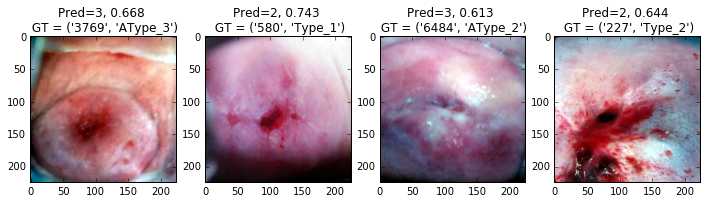

In [32]:
for x, y_true, info in flow:
    s = y_true.shape[0]
    y_pred = vgg.predict(x)
    print("--", total_counter*batch_size + s)    
    total_counter += 1
    plt_st(12, 4)
    for i in range(s):
        print(info[i], y_pred[i], y_true[i])
        plt.subplot(1, s, i+1)
        plt.title("Pred={}, {:.3f} \n GT = {}".format(np.argmax(y_pred[i])+1, np.max(y_pred[i]), info[i]))
        plt.imshow(scale_percentile(x[i, :, :, :].transpose([1, 2, 0])))
    break

In [19]:
(y_pred > 0.5).astype(np.float32)

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]], dtype=float32)

### Cross-Validation logs


```
optimizer = 'adam'
lr_base = 0.000001
names_to_train=[            
    #'block3_conv1',     #'block3_conv2',    #'block3_conv3',
    #'block4_conv1',    #'block4_conv2',
    'block4_conv3',
    'block5_conv1',    'block5_conv2',    'block5_conv3',
]
nb_epochs = 30
batch_size = 4

load_best_weights = False

# Iterate over folds
n_folds = 7
val_fold_index = 0
```

```
---- Validation fold index:  0 / 7
(5740, 1070)
[0.3019163763066202, 0.3735191637630662, 0.3245644599303136]
[0.3299065420560748, 0.32897196261682243, 0.34112149532710284]

 2017-05-11 00:05:48.421505 - Get VGG16 model ...

 2017-05-11 00:05:48.864269 - Start training ...

-- Training parameters: 4, 30, 5744, 1072
('Image normalization: ', 'vgg')

-- Fit model
Epoch 1/30
5744/5744 [==============================] - 2165s - loss: 2.5679 - acc: 0.3459 - precision: 0.3474 - recall: 0.3243 - val_loss: 2.0182 - val_acc: 0.3657 - val_precision: 0.3678 - val_recall: 0.3312
Epoch 2/30
5744/5744 [==============================] - 2158s - loss: 1.4813 - acc: 0.3691 - precision: 0.3730 - recall: 0.2993 - val_loss: 1.4527 - val_acc: 0.3638 - val_precision: 0.3492 - val_recall: 0.2789
Epoch 3/30
5744/5744 [==============================] - 2155s - loss: 1.2554 - acc: 0.3874 - precision: 0.4044 - recall: 0.2803 - val_loss: 1.2681 - val_acc: 0.3871 - val_precision: 0.4005 - val_recall: 0.2780
Epoch 4/30
5744/5744 [==============================] - 2156s - loss: 1.1634 - acc: 0.4135 - precision: 0.4201 - recall: 0.2648 - val_loss: 1.1754 - val_acc: 0.4142 - val_precision: 0.4241 - val_recall: 0.2724
Epoch 5/30
5744/5744 [==============================] - 2156s - loss: 1.1108 - acc: 0.4224 - precision: 0.4323 - recall: 0.2488 - val_loss: 1.1566 - val_acc: 0.4291 - val_precision: 0.4487 - val_recall: 0.2733
Epoch 6/30
5744/5744 [==============================] - 2157s - loss: 1.0613 - acc: 0.4504 - precision: 0.4789 - recall: 0.2733 - val_loss: 1.0719 - val_acc: 0.4412 - val_precision: 0.4723 - val_recall: 0.3060
Epoch 7/30
5744/5744 [==============================] - 2155s - loss: 1.0298 - acc: 0.4721 - precision: 0.5013 - recall: 0.2956 - val_loss: 1.0512 - val_acc: 0.4664 - val_precision: 0.4916 - val_recall: 0.3116
Epoch 8/30
5744/5744 [==============================] - 2155s - loss: 1.0158 - acc: 0.4847 - precision: 0.5187 - recall: 0.3081 - val_loss: 1.0288 - val_acc: 0.5019 - val_precision: 0.5227 - val_recall: 0.3312
Epoch 9/30
5744/5744 [==============================] - 2155s - loss: 1.0024 - acc: 0.4958 - precision: 0.5402 - recall: 0.3238 - val_loss: 1.0467 - val_acc: 0.4608 - val_precision: 0.5087 - val_recall: 0.3293
Epoch 10/30
5744/5744 [==============================] - 2156s - loss: 0.9989 - acc: 0.4950 - precision: 0.5469 - recall: 0.3297 - val_loss: 1.0064 - val_acc: 0.4897 - val_precision: 0.5255 - val_recall: 0.3377
Epoch 11/30
5744/5744 [==============================] - 2156s - loss: 0.9735 - acc: 0.5223 - precision: 0.5638 - recall: 0.3496 - val_loss: 0.9995 - val_acc: 0.5093 - val_precision: 0.5454 - val_recall: 0.3554
Epoch 12/30
5744/5744 [==============================] - 2155s - loss: 0.9775 - acc: 0.5160 - precision: 0.5553 - recall: 0.3482 - val_loss: 1.0149 - val_acc: 0.4869 - val_precision: 0.5519 - val_recall: 0.3507
Epoch 13/30
5744/5744 [==============================] - 2155s - loss: 0.9591 - acc: 0.5277 - precision: 0.5773 - recall: 0.3592 - val_loss: 0.9692 - val_acc: 0.5168 - val_precision: 0.5718 - val_recall: 0.3825
Epoch 14/30
5744/5744 [==============================] - 2159s - loss: 0.9583 - acc: 0.5359 - precision: 0.5828 - recall: 0.3736 - val_loss: 0.9646 - val_acc: 0.5326 - val_precision: 0.5752 - val_recall: 0.3815
Epoch 15/30
5744/5744 [==============================] - 2160s - loss: 0.9470 - acc: 0.5433 - precision: 0.6045 - recall: 0.3903 - val_loss: 0.9889 - val_acc: 0.5289 - val_precision: 0.5905 - val_recall: 0.3927
Epoch 16/30
5744/5744 [==============================] - 2159s - loss: 0.9474 - acc: 0.5348 - precision: 0.5818 - recall: 0.3783 - val_loss: 0.9558 - val_acc: 0.5494 - val_precision: 0.6154 - val_recall: 0.4058
Epoch 17/30
5744/5744 [==============================] - 2159s - loss: 0.9303 - acc: 0.5524 - precision: 0.5970 - recall: 0.3955 - val_loss: 0.9429 - val_acc: 0.5289 - val_precision: 0.5868 - val_recall: 0.4095
Epoch 18/30
5744/5744 [==============================] - 2159s - loss: 0.9225 - acc: 0.5566 - precision: 0.6000 - recall: 0.4044 - val_loss: 0.9612 - val_acc: 0.5243 - val_precision: 0.5958 - val_recall: 0.4030
Epoch 19/30
5744/5744 [==============================] - 2159s - loss: 0.9366 - acc: 0.5475 - precision: 0.5998 - recall: 0.4029 - val_loss: 0.9571 - val_acc: 0.5401 - val_precision: 0.5743 - val_recall: 0.4021
Epoch 20/30
5744/5744 [==============================] - 2156s - loss: 0.9295 - acc: 0.5515 - precision: 0.6032 - recall: 0.4044 - val_loss: 0.9580 - val_acc: 0.5550 - val_precision: 0.6095 - val_recall: 0.4263
Epoch 21/30
5744/5744 [==============================] - 2156s - loss: 0.9292 - acc: 0.5482 - precision: 0.5929 - recall: 0.4036 - val_loss: 0.9674 - val_acc: 0.5410 - val_precision: 0.6001 - val_recall: 0.4160
Epoch 22/30
5744/5744 [==============================] - 2157s - loss: 0.9256 - acc: 0.5548 - precision: 0.5966 - recall: 0.4128 - val_loss: 0.9547 - val_acc: 0.5420 - val_precision: 0.5939 - val_recall: 0.4076
Epoch 23/30
5744/5744 [==============================] - 2157s - loss: 0.9176 - acc: 0.5616 - precision: 0.6092 - recall: 0.4123 - val_loss: 0.9421 - val_acc: 0.5466 - val_precision: 0.5886 - val_recall: 0.4170


 ---- Validation fold index:  1 / 7
(5754, 1070)
[0.3069169273548836, 0.37417448731317343, 0.318908585331943]
[0.3233644859813084, 0.3205607476635514, 0.3560747663551402]

 2017-05-11 13:53:04.320209 - Get VGG16 model ...

 2017-05-11 13:53:04.737887 - Start training ...

-- Training parameters: 4, 30, 5756, 1072
('Image normalization: ', 'vgg')

-- Fit model
Epoch 1/30
5756/5756 [==============================] - 2170s - loss: 2.6229 - acc: 0.3518 - precision: 0.3521 - recall: 0.3275 - val_loss: 1.9103 - val_acc: 0.3713 - val_precision: 0.3728 - val_recall: 0.3396
Epoch 2/30
5756/5756 [==============================] - 2171s - loss: 1.5397 - acc: 0.3652 - precision: 0.3625 - recall: 0.2940 - val_loss: 1.4041 - val_acc: 0.3825 - val_precision: 0.3912 - val_recall: 0.3106
Epoch 3/30
5756/5756 [==============================] - 2170s - loss: 1.2623 - acc: 0.3787 - precision: 0.3864 - recall: 0.2592 - val_loss: 1.2646 - val_acc: 0.3937 - val_precision: 0.4042 - val_recall: 0.2724
Epoch 4/30
5756/5756 [==============================] - 2171s - loss: 1.1715 - acc: 0.3899 - precision: 0.3981 - recall: 0.2236 - val_loss: 1.1612 - val_acc: 0.4095 - val_precision: 0.4070 - val_recall: 0.2519
Epoch 5/30
5756/5756 [==============================] - 2170s - loss: 1.1448 - acc: 0.3958 - precision: 0.3801 - recall: 0.1918 - val_loss: 1.1302 - val_acc: 0.4142 - val_precision: 0.4303 - val_recall: 0.2463
Epoch 6/30
5756/5756 [==============================] - 2173s - loss: 1.0887 - acc: 0.4236 - precision: 0.4149 - recall: 0.2074 - val_loss: 1.1020 - val_acc: 0.4160 - val_precision: 0.4303 - val_recall: 0.2500
Epoch 7/30
5756/5756 [==============================] - 2172s - loss: 1.0757 - acc: 0.4342 - precision: 0.4438 - recall: 0.2201 - val_loss: 1.1096 - val_acc: 0.4356 - val_precision: 0.4506 - val_recall: 0.2715
Epoch 8/30
5756/5756 [==============================] - 2172s - loss: 1.0520 - acc: 0.4454 - precision: 0.4578 - recall: 0.2224 - val_loss: 1.0560 - val_acc: 0.4683 - val_precision: 0.5187 - val_recall: 0.3022
Epoch 9/30
5756/5756 [==============================] - 2175s - loss: 1.0354 - acc: 0.4692 - precision: 0.4762 - recall: 0.2557 - val_loss: 1.0167 - val_acc: 0.4879 - val_precision: 0.5376 - val_recall: 0.3162
Epoch 10/30
1488/5756 [======>.......................] - ETA: 1456s - loss: 1.0249 - acc: 0.4798 - precision: 0.5607 - recall: 0.2762
```

### Logs

#### Case 1
Fine-tunned layers : 
```
'block4_conv1',
'block4_conv2',
'block4_conv3',

'block5_conv1',
'block5_conv2',
'block5_conv3',
```
##### A) 

```
2017-05-05 00:07:22.048068 - Start training ...

-- Training parameters: 4, 50, 2752, 488
('Image normalization: ', 'vgg')

-- Fit model
Epoch 1/50
2752/2752 [==============================] - 821s - loss: 1.7259 - acc: 0.3914 - precision: 0.4069 - recall: 0.2943 - val_loss: 1.1059 - val_acc: 0.4242 - val_precision: 0.4522 - val_recall: 0.2807
Epoch 2/50
2752/2752 [==============================] - 820s - loss: 1.0667 - acc: 0.4419 - precision: 0.4583 - recall: 0.2336 - val_loss: 1.1003 - val_acc: 0.4180 - val_precision: 0.3975 - val_recall: 0.2459
Epoch 3/50
2752/2752 [==============================] - 820s - loss: 1.0121 - acc: 0.4993 - precision: 0.5464 - recall: 0.2860 - val_loss: 0.9827 - val_acc: 0.4816 - val_precision: 0.5745 - val_recall: 0.3074
Epoch 4/50
2752/2752 [==============================] - 820s - loss: 0.9934 - acc: 0.4967 - precision: 0.5329 - recall: 0.3056 - val_loss: 0.9402 - val_acc: 0.5143 - val_precision: 0.5471 - val_recall: 0.3730
Epoch 5/50
2752/2752 [==============================] - 820s - loss: 0.9725 - acc: 0.5222 - precision: 0.5610 - recall: 0.3085 - val_loss: 0.9221 - val_acc: 0.5656 - val_precision: 0.5820 - val_recall: 0.3525
Epoch 6/50
2752/2752 [==============================] - 820s - loss: 0.9490 - acc: 0.5403 - precision: 0.6021 - recall: 0.3572 - val_loss: 0.8519 - val_acc: 0.5902 - val_precision: 0.6544 - val_recall: 0.4877
Epoch 7/50
2752/2752 [==============================] - 819s - loss: 0.9325 - acc: 0.5447 - precision: 0.6169 - recall: 0.3786 - val_loss: 0.9162 - val_acc: 0.5574 - val_precision: 0.6339 - val_recall: 0.4283
Epoch 8/50
2752/2752 [==============================] - 819s - loss: 0.9000 - acc: 0.5774 - precision: 0.6430 - recall: 0.4055 - val_loss: 0.8997 - val_acc: 0.5676 - val_precision: 0.6284 - val_recall: 0.4939
Epoch 9/50
2752/2752 [==============================] - 819s - loss: 0.9030 - acc: 0.5756 - precision: 0.6290 - recall: 0.4095 - val_loss: 0.8627 - val_acc: 0.5881 - val_precision: 0.6421 - val_recall: 0.4570
Epoch 10/50
2752/2752 [==============================] - 819s - loss: 0.8788 - acc: 0.5879 - precision: 0.6491 - recall: 0.4324 - val_loss: 0.8724 - val_acc: 0.6066 - val_precision: 0.6796 - val_recall: 0.4467
Epoch 11/50
2752/2752 [==============================] - 819s - loss: 0.8699 - acc: 0.5818 - precision: 0.6663 - recall: 0.4331 - val_loss: 0.8387 - val_acc: 0.6004 - val_precision: 0.6387 - val_recall: 0.5266
Epoch 12/50
2752/2752 [==============================] - 819s - loss: 0.8702 - acc: 0.5890 - precision: 0.6701 - recall: 0.4448 - val_loss: 0.8563 - val_acc: 0.6127 - val_precision: 0.6428 - val_recall: 0.4898
Epoch 13/50
2752/2752 [==============================] - 820s - loss: 0.8704 - acc: 0.5894 - precision: 0.6650 - recall: 0.4408 - val_loss: 0.8369 - val_acc: 0.6230 - val_precision: 0.6728 - val_recall: 0.4488
Epoch 14/50
2752/2752 [==============================] - 820s - loss: 0.8601 - acc: 0.5930 - precision: 0.6808 - recall: 0.4473 - val_loss: 0.8042 - val_acc: 0.6496 - val_precision: 0.7022 - val_recall: 0.4939
Epoch 15/50
2752/2752 [==============================] - 817s - loss: 0.8333 - acc: 0.6090 - precision: 0.6890 - recall: 0.4789 - val_loss: 0.8065 - val_acc: 0.6352 - val_precision: 0.6762 - val_recall: 0.5205
Epoch 16/50
2752/2752 [==============================] - 817s - loss: 0.8247 - acc: 0.6286 - precision: 0.6954 - recall: 0.5062 - val_loss: 0.8257 - val_acc: 0.6025 - val_precision: 0.6913 - val_recall: 0.4816
Epoch 17/50
2752/2752 [==============================] - 817s - loss: 0.8272 - acc: 0.6141 - precision: 0.6853 - recall: 0.4746 - val_loss: 0.8081 - val_acc: 0.6189 - val_precision: 0.6824 - val_recall: 0.5143
Epoch 18/50
2752/2752 [==============================] - 817s - loss: 0.8267 - acc: 0.6257 - precision: 0.6931 - recall: 0.4884 - val_loss: 0.7923 - val_acc: 0.6475 - val_precision: 0.6872 - val_recall: 0.5061
Epoch 19/50
2752/2752 [==============================] - 817s - loss: 0.8101 - acc: 0.6305 - precision: 0.6893 - recall: 0.5073 - val_loss: 0.8584 - val_acc: 0.6270 - val_precision: 0.6749 - val_recall: 0.5246
Epoch 20/50
2752/2752 [==============================] - 817s - loss: 0.8173 - acc: 0.6250 - precision: 0.6797 - recall: 0.4985 - val_loss: 0.8036 - val_acc: 0.6189 - val_precision: 0.6735 - val_recall: 0.5123
Epoch 21/50
2752/2752 [==============================] - 817s - loss: 0.8123 - acc: 0.6243 - precision: 0.6836 - recall: 0.5065 - val_loss: 0.8404 - val_acc: 0.6455 - val_precision: 0.6783 - val_recall: 0.5307
Epoch 22/50
2752/2752 [==============================] - 817s - loss: 0.7905 - acc: 0.6392 - precision: 0.7025 - recall: 0.5269 - val_loss: 0.8000 - val_acc: 0.6311 - val_precision: 0.6633 - val_recall: 0.5348
Epoch 23/50
2752/2752 [==============================] - 817s - loss: 0.7798 - acc: 0.6468 - precision: 0.7167 - recall: 0.5418 - val_loss: 0.8272 - val_acc: 0.6332 - val_precision: 0.6660 - val_recall: 0.5143
Epoch 24/50
2752/2752 [==============================] - 817s - loss: 0.7870 - acc: 0.6428 - precision: 0.7000 - recall: 0.5265 - val_loss: 0.7895 - val_acc: 0.6393 - val_precision: 0.6940 - val_recall: 0.5389
Epoch 25/50
2752/2752 [==============================] - 817s - loss: 0.7712 - acc: 0.6530 - precision: 0.7094 - recall: 0.5345 - val_loss: 0.7987 - val_acc: 0.6598 - val_precision: 0.7029 - val_recall: 0.5840
Epoch 26/50
2752/2752 [==============================] - 817s - loss: 0.7814 - acc: 0.6384 - precision: 0.6983 - recall: 0.5443 - val_loss: 0.8049 - val_acc: 0.6393 - val_precision: 0.7042 - val_recall: 0.5656
Epoch 27/50
2752/2752 [==============================] - 817s - loss: 0.7781 - acc: 0.6483 - precision: 0.7102 - recall: 0.5382 - val_loss: 0.7651 - val_acc: 0.6455 - val_precision: 0.7029 - val_recall: 0.5430
Epoch 28/50
2752/2752 [==============================] - 817s - loss: 0.7783 - acc: 0.6464 - precision: 0.7223 - recall: 0.5302 - val_loss: 0.8548 - val_acc: 0.6434 - val_precision: 0.6667 - val_recall: 0.5615
Epoch 29/50
2752/2752 [==============================] - 817s - loss: 0.7724 - acc: 0.6483 - precision: 0.7075 - recall: 0.5545 - val_loss: 0.7486 - val_acc: 0.6926 - val_precision: 0.7404 - val_recall: 0.5799
Epoch 30/50
2752/2752 [==============================] - 817s - loss: 0.7686 - acc: 0.6377 - precision: 0.7191 - recall: 0.5352 - val_loss: 0.8124 - val_acc: 0.6332 - val_precision: 0.6680 - val_recall: 0.5574
Epoch 31/50
2752/2752 [==============================] - 817s - loss: 0.7671 - acc: 0.6588 - precision: 0.7111 - recall: 0.5425 - val_loss: 0.7716 - val_acc: 0.6434 - val_precision: 0.6872 - val_recall: 0.5738
Epoch 32/50
2752/2752 [==============================] - 817s - loss: 0.7686 - acc: 0.6548 - precision: 0.7152 - recall: 0.5538 - val_loss: 0.8182 - val_acc: 0.6250 - val_precision: 0.6633 - val_recall: 0.5348
Epoch 33/50
2752/2752 [==============================] - 817s - loss: 0.7642 - acc: 0.6541 - precision: 0.7179 - recall: 0.5578 - val_loss: 0.7787 - val_acc: 0.6619 - val_precision: 0.6940 - val_recall: 0.5738
Epoch 34/50
2752/2752 [==============================] - 817s - loss: 0.7525 - acc: 0.6555 - precision: 0.7179 - recall: 0.5509 - val_loss: 0.8170 - val_acc: 0.6455 - val_precision: 0.7015 - val_recall: 0.5861
Epoch 35/50
2752/2752 [==============================] - 817s - loss: 0.7648 - acc: 0.6461 - precision: 0.7162 - recall: 0.5531 - val_loss: 0.7785 - val_acc: 0.6393 - val_precision: 0.6906 - val_recall: 0.5758
Epoch 36/50
2752/2752 [==============================] - 819s - loss: 0.7551 - acc: 0.6592 - precision: 0.7275 - recall: 0.5632 - val_loss: 0.7726 - val_acc: 0.6619 - val_precision: 0.6933 - val_recall: 0.5635
Epoch 37/50
2752/2752 [==============================] - 820s - loss: 0.7523 - acc: 0.6562 - precision: 0.7236 - recall: 0.5560 - val_loss: 0.7856 - val_acc: 0.6701 - val_precision: 0.6844 - val_recall: 0.5820
Epoch 38/50
2752/2752 [==============================] - 820s - loss: 0.7513 - acc: 0.6588 - precision: 0.7277 - recall: 0.5570 - val_loss: 0.7575 - val_acc: 0.6496 - val_precision: 0.6926 - val_recall: 0.5697
Epoch 39/50
2752/2752 [==============================] - 820s - loss: 0.7509 - acc: 0.6639 - precision: 0.7212 - recall: 0.5618 - val_loss: 0.8067 - val_acc: 0.6578 - val_precision: 0.6878 - val_recall: 0.5738
Epoch 40/50
2752/2752 [==============================] - 821s - loss: 0.7434 - acc: 0.6715 - precision: 0.7328 - recall: 0.5778 - val_loss: 0.7907 - val_acc: 0.6537 - val_precision: 0.6967 - val_recall: 0.5717
Epoch 41/50
2752/2752 [==============================] - 821s - loss: 0.7398 - acc: 0.6701 - precision: 0.7323 - recall: 0.5709 - val_loss: 0.8178 - val_acc: 0.6189 - val_precision: 0.6455 - val_recall: 0.5615
Epoch 42/50
2752/2752 [==============================] - 821s - loss: 0.7489 - acc: 0.6610 - precision: 0.7330 - recall: 0.5636 - val_loss: 0.7329 - val_acc: 0.6496 - val_precision: 0.6974 - val_recall: 0.5840
Epoch 43/50
2752/2752 [==============================] - 821s - loss: 0.7436 - acc: 0.6708 - precision: 0.7293 - recall: 0.5701 - val_loss: 0.7863 - val_acc: 0.6742 - val_precision: 0.7049 - val_recall: 0.5984
Epoch 44/50
2752/2752 [==============================] - 821s - loss: 0.7496 - acc: 0.6613 - precision: 0.7255 - recall: 0.5650 - val_loss: 0.7375 - val_acc: 0.6721 - val_precision: 0.7042 - val_recall: 0.5779
Epoch 45/50
2752/2752 [==============================] - 821s - loss: 0.7532 - acc: 0.6584 - precision: 0.7185 - recall: 0.5654 - val_loss: 0.7947 - val_acc: 0.6332 - val_precision: 0.6749 - val_recall: 0.5717
Epoch 46/50
2752/2752 [==============================] - 821s - loss: 0.7450 - acc: 0.6621 - precision: 0.7168 - recall: 0.5752 - val_loss: 0.7546 - val_acc: 0.6701 - val_precision: 0.7001 - val_recall: 0.5984
Epoch 47/50
2752/2752 [==============================] - 821s - loss: 0.7505 - acc: 0.6602 - precision: 0.7194 - recall: 0.5687 - val_loss: 0.7793 - val_acc: 0.6311 - val_precision: 0.6940 - val_recall: 0.5697
Epoch 48/50
2752/2752 [==============================] - 821s - loss: 0.7424 - acc: 0.6661 - precision: 0.7221 - recall: 0.5596 - val_loss: 0.7670 - val_acc: 0.6721 - val_precision: 0.7042 - val_recall: 0.5881
Epoch 49/50
2752/2752 [==============================] - 821s - loss: 0.7521 - acc: 0.6559 - precision: 0.7236 - recall: 0.5581 - val_loss: 0.7907 - val_acc: 0.6660 - val_precision: 0.6947 - val_recall: 0.5779
Epoch 50/50
2752/2752 [==============================] - 821s - loss: 0.7476 - acc: 0.6595 - precision: 0.7284 - recall: 0.5730 - val_loss: 0.8088 - val_acc: 0.6291 - val_precision: 0.6858 - val_recall: 0.5451
```


#### Case 2
Fine-tunned layers : 
```
'block5_conv1',
'block5_conv2',
'block5_conv3',
```
##### A) 
```
seed=54321
optimizer = 'adam'
lr_base = 0.0001
```
50 epochs ->  val_loss=1.0994 val_acc=0.2848 val_precision=0.0000 val_recall=0.0000

##### B) 
```
seed=54321
optimizer = 'adam'
lr_base = 0.00001
```
```
2017-05-04 19:43:40.613411 - Start training ...

-- Training parameters: 4, 50, 2752, 488
('Image normalization: ', 'vgg')

-- Fit model
Epoch 1/50
2752/2752 [==============================] - 922s - loss: 0.8637 - acc: 0.5905 - precision: 0.6713 - recall: 0.4146 - val_loss: 0.8768 - val_acc: 0.5635 - val_precision: 0.5943 - val_recall: 0.4529
Epoch 2/50
2752/2752 [==============================] - 538s - loss: 0.8778 - acc: 0.5727 - precision: 0.6424 - recall: 0.3968 - val_loss: 0.8671 - val_acc: 0.5840 - val_precision: 0.6455 - val_recall: 0.4652
Epoch 3/50
2752/2752 [==============================] - 539s - loss: 0.8672 - acc: 0.5807 - precision: 0.6586 - recall: 0.4015 - val_loss: 0.9168 - val_acc: 0.5881 - val_precision: 0.6400 - val_recall: 0.4467
Epoch 4/50
2752/2752 [==============================] - 539s - loss: 0.8715 - acc: 0.5763 - precision: 0.6508 - recall: 0.4070 - val_loss: 0.8438 - val_acc: 0.6004 - val_precision: 0.6202 - val_recall: 0.4549
Epoch 5/50
2752/2752 [==============================] - 540s - loss: 0.8670 - acc: 0.5687 - precision: 0.6372 - recall: 0.4055 - val_loss: 0.9181 - val_acc: 0.5922 - val_precision: 0.6455 - val_recall: 0.4836
Epoch 6/50
2752/2752 [==============================] - 538s - loss: 0.8662 - acc: 0.5825 - precision: 0.6704 - recall: 0.4102 - val_loss: 0.8506 - val_acc: 0.5943 - val_precision: 0.6195 - val_recall: 0.4508
Epoch 7/50
2752/2752 [==============================] - 539s - loss: 0.8639 - acc: 0.5901 - precision: 0.6592 - recall: 0.4193 - val_loss: 0.8947 - val_acc: 0.5902 - val_precision: 0.6175 - val_recall: 0.4631
Epoch 8/50
2752/2752 [==============================] - 539s - loss: 0.8833 - acc: 0.5680 - precision: 0.6260 - recall: 0.4026 - val_loss: 0.8725 - val_acc: 0.6025 - val_precision: 0.6236 - val_recall: 0.4385
Epoch 9/50
2752/2752 [==============================] - 538s - loss: 0.8799 - acc: 0.5734 - precision: 0.6309 - recall: 0.4055 - val_loss: 0.8772 - val_acc: 0.5615 - val_precision: 0.6325 - val_recall: 0.4652
Epoch 10/50
2752/2752 [==============================] - 538s - loss: 0.8574 - acc: 0.5828 - precision: 0.6670 - recall: 0.4161 - val_loss: 0.8915 - val_acc: 0.5840 - val_precision: 0.6189 - val_recall: 0.4775
Epoch 11/50
2752/2752 [==============================] - 538s - loss: 0.8606 - acc: 0.5919 - precision: 0.6611 - recall: 0.4175 - val_loss: 0.8987 - val_acc: 0.5471 - val_precision: 0.6250 - val_recall: 0.4488
Epoch 12/50
2752/2752 [==============================] - 538s - loss: 0.8687 - acc: 0.5818 - precision: 0.6686 - recall: 0.4215 - val_loss: 0.8773 - val_acc: 0.5902 - val_precision: 0.6428 - val_recall: 0.4693
Epoch 13/50
2752/2752 [==============================] - 538s - loss: 0.8791 - acc: 0.5916 - precision: 0.6532 - recall: 0.4041 - val_loss: 0.8911 - val_acc: 0.5717 - val_precision: 0.6134 - val_recall: 0.4775
Epoch 14/50
2752/2752 [==============================] - 538s - loss: 0.8670 - acc: 0.5698 - precision: 0.6539 - recall: 0.4142 - val_loss: 0.8804 - val_acc: 0.5717 - val_precision: 0.6141 - val_recall: 0.4590
Epoch 15/50
2752/2752 [==============================] - 538s - loss: 0.8635 - acc: 0.5807 - precision: 0.6547 - recall: 0.4168 - val_loss: 0.8553 - val_acc: 0.5861 - val_precision: 0.6318 - val_recall: 0.4672
Epoch 16/50
2752/2752 [==============================] - 538s - loss: 0.8643 - acc: 0.5843 - precision: 0.6609 - recall: 0.4204 - val_loss: 0.8974 - val_acc: 0.5902 - val_precision: 0.6175 - val_recall: 0.4549
Epoch 17/50
2752/2752 [==============================] - 538s - loss: 0.8602 - acc: 0.5876 - precision: 0.6722 - recall: 0.4201 - val_loss: 0.9237 - val_acc: 0.5553 - val_precision: 0.5738 - val_recall: 0.4324
Epoch 18/50
2752/2752 [==============================] - 538s - loss: 0.8717 - acc: 0.5796 - precision: 0.6443 - recall: 0.4135 - val_loss: 0.8633 - val_acc: 0.5758 - val_precision: 0.6277 - val_recall: 0.4426
Epoch 19/50
2752/2752 [==============================] - 538s - loss: 0.8694 - acc: 0.5759 - precision: 0.6555 - recall: 0.4175 - val_loss: 0.9126 - val_acc: 0.5881 - val_precision: 0.6434 - val_recall: 0.4693
Epoch 20/50
2752/2752 [==============================] - 537s - loss: 0.8601 - acc: 0.5876 - precision: 0.6621 - recall: 0.4102 - val_loss: 0.9043 - val_acc: 0.5512 - val_precision: 0.5949 - val_recall: 0.4303
Epoch 21/50
2752/2752 [==============================] - 537s - loss: 0.8691 - acc: 0.5727 - precision: 0.6573 - recall: 0.4095 - val_loss: 0.8671 - val_acc: 0.6025 - val_precision: 0.6407 - val_recall: 0.4611
Epoch 22/50
2752/2752 [==============================] - 537s - loss: 0.8756 - acc: 0.5799 - precision: 0.6437 - recall: 0.4113 - val_loss: 0.8886 - val_acc: 0.5717 - val_precision: 0.5984 - val_recall: 0.4693
Epoch 23/50
2752/2752 [==============================] - 537s - loss: 0.8720 - acc: 0.5778 - precision: 0.6526 - recall: 0.4132 - val_loss: 0.9069 - val_acc: 0.5656 - val_precision: 0.5977 - val_recall: 0.4426
Epoch 24/50
2752/2752 [==============================] - 537s - loss: 0.8701 - acc: 0.5763 - precision: 0.6490 - recall: 0.4201 - val_loss: 0.8721 - val_acc: 0.5861 - val_precision: 0.6352 - val_recall: 0.4570
Epoch 25/50
2752/2752 [==============================] - 537s - loss: 0.8598 - acc: 0.5970 - precision: 0.6503 - recall: 0.4208 - val_loss: 0.9022 - val_acc: 0.5635 - val_precision: 0.6346 - val_recall: 0.4529
Epoch 26/50
2752/2752 [==============================] - 537s - loss: 0.8733 - acc: 0.5759 - precision: 0.6447 - recall: 0.4124 - val_loss: 0.9149 - val_acc: 0.5820 - val_precision: 0.6093 - val_recall: 0.4775
Epoch 27/50
2752/2752 [==============================] - 542s - loss: 0.8591 - acc: 0.5847 - precision: 0.6562 - recall: 0.4168 - val_loss: 0.8743 - val_acc: 0.5943 - val_precision: 0.6387 - val_recall: 0.4672
Epoch 28/50
2752/2752 [==============================] - 541s - loss: 0.8670 - acc: 0.5767 - precision: 0.6664 - recall: 0.4033 - val_loss: 0.8681 - val_acc: 0.5799 - val_precision: 0.6052 - val_recall: 0.4734
Epoch 29/50
 548/2752 [====>.........................] - ETA: 389s - loss: 0.8738 - acc: 0.5730 - precision: 0.6235 - recall: 0.4069
```
